# Neural Network & Naive Bayes
#### Awadh Ahmed

The goal here was to predict the likelihood that clients of a certain bank would default on their loan payments.
To this extent we've used Naive Bayes and Neural Network algorithms for our predicitons.

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

D:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# Our Database

df = pd.read_csv("default of credit card clients.csv")
df.set_index("ID", inplace=True, drop=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 1. Simple EDA

Text(0, 0.5, 'Count')

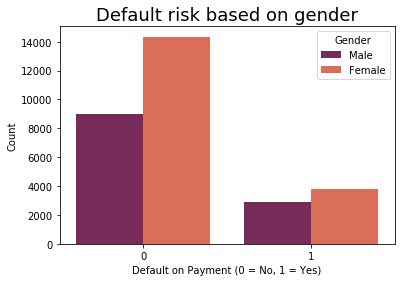

In [3]:
# Visualizing if there is any relation between gender and chance of default using seaborn

g = sns.countplot(x="default payment next month",hue="SEX", data=df, palette='rocket')

plt.legend(title='Gender', loc='upper right', labels=['Male', 'Female'])
plt.title("Default risk based on gender", size=18)
plt.xlabel("Default on Payment (0 = No, 1 = Yes)")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

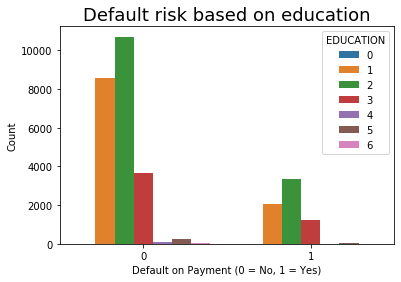

In [4]:
# Visualizing if there is any relation between education and chance of default

g = sns.countplot(x="default payment next month",hue="EDUCATION", data=df)

#plt.legend(title='Education', loc='upper right', labels=['Male', 'Female'])
plt.title("Default risk based on education", size=18)
plt.xlabel("Default on Payment (0 = No, 1 = Yes)")
plt.ylabel("Count")

### 2. Preprocessing

Processing our data before applying scikit algorithims

In [5]:
# Using LabelEncoder() on our  categorical data
# This helps convert our nominal feaatures into something our algorithms can understand

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df['SEX'] = le.fit_transform(df.SEX)
df['EDUCATION'] = le.fit_transform(df.EDUCATION)
df['MARRIAGE'] = le.fit_transform(df.MARRIAGE)
df['PAY_0'] = le.fit_transform(df.PAY_0)
df['PAY_2'] = le.fit_transform(df.PAY_2)
df['PAY_3'] = le.fit_transform(df.PAY_3)
df['PAY_4'] = le.fit_transform(df.PAY_4)
df['PAY_5'] = le.fit_transform(df.PAY_5)
df['PAY_6'] = le.fit_transform(df.PAY_6)
df['default payment next month'] = le.fit_transform(df["default payment next month"])

In [6]:
# Scaling our numerical featurs
# This is done to normalise our data ranges
# I've standardized the data from scratch

num_features = ['LIMIT_BAL','BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT4','BILL_AMT5','BILL_AMT6',
               'PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

scaled_features = {}
for f in num_features:
    mean = df[f].mean()
    std = df[f].std()
    scaled_features[f] = [mean,std]
    df.loc[:, f] = (df[f] - mean)/std

In [7]:
# Quick sanity check to see what our data looks like

df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,
1,-1.136701,1,2,1,24,4,4,1,1,0,...,-0.672486,-0.663047,-0.652713,-0.341936,-0.227082,-0.296796,-0.308057,-0.314131,-0.293377,1
2,-0.365974,1,2,2,26,1,4,2,2,2,...,-0.621626,-0.606219,-0.597956,-0.341936,-0.213584,-0.240001,-0.244226,-0.314131,-0.180875,1
3,-0.597192,1,2,2,34,2,2,2,2,2,...,-0.449723,-0.417181,-0.391623,-0.250287,-0.191884,-0.240001,-0.244226,-0.248679,-0.012122,0
4,-0.905483,1,2,1,37,2,2,2,2,2,...,-0.232369,-0.186726,-0.156576,-0.221187,-0.169358,-0.228641,-0.237842,-0.244162,-0.237126,0
5,-0.905483,0,2,1,57,1,2,1,2,2,...,-0.346991,-0.348131,-0.331476,-0.221187,1.335012,0.271161,0.266429,-0.269034,-0.255183,0


In [8]:
# Creating our train, test splits for our data

from sklearn.model_selection import train_test_split

X = df.values[:,:23]
y = df.values[:,23]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=10)

### 3. Implementing Algorithims
Implementing our Naive Bayes & Neural Network algorithims by scratch using scikit

In [9]:
# Naive Bayes
# The model gives us an accuracy of 0.645

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

clf = GaussianNB()
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
accuracy_score(y_test, pred, normalize = True)

0.6457777777777778

In [14]:
# Neural Network

from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(X_train, y_train)

nn_predict = mlp.predict(X_test)

In [15]:
# Printing out our confusion matrix & clssification report of our algorithim
# The algorithim does very well at prediciting if a client wont default on their payments
# But poorly when it comes to prediciting if a client will default
# The overall accuracy of our model is 0.82

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test,nn_predict))
print(classification_report(y_test,nn_predict))

[[6625  357]
 [1280  738]]
              precision    recall  f1-score   support

         0.0       0.84      0.95      0.89      6982
         1.0       0.67      0.37      0.47      2018

    accuracy                           0.82      9000
   macro avg       0.76      0.66      0.68      9000
weighted avg       0.80      0.82      0.80      9000

